In [1]:
### SETUP ###
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow_hub as hub


dirname = '/kaggle/input/'

class_count = 4
ds_size = 480

batch_size = 32
img_height = 224
img_width = 224

## Reference: https://www.tensorflow.org/tutorials/images/classification
## Use 80% of the images for training and 20% for validation.
## Below is 80% of Training
train_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.20,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

## Below is the 20% for Validation
test_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.20,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

## Creating test and validation datasets (10%-10%)
## Reference; https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test#:~:text=A%20robust%20way%20to%20split,by%20filtering%20by%20the%20bucket.
val_size = int(0.1 * ds_size)
test_size = int(0.1 * ds_size)

validation_ds = test_ds.take(val_size)
testing_ds = test_ds.skip(test_size)
print(f"testing_ds: {testing_ds}")
print(f"validation: {validation_ds}")

## Class Names
class_names = train_ds.class_names
print(test_ds.class_names)

## Do data augmentation to training and validation set only
## Reference: https://pyimagesearch.com/2021/06/28/data-augmentation-with-tf-data-and-tensorflow/



Found 480 files belonging to 5 classes.
Using 384 files for training.


2022-12-03 04:48:28.327641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 04:48:28.328683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 04:48:28.673126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 04:48:28.674153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 04:48:28.675129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 480 files belonging to 5 classes.
Using 96 files for validation.
testing_ds: <SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
validation: <TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
['anudari', 'cebastien', 'christopher', 'michael', 'michael-model2']


2022-12-03 04:48:33.869514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-03 04:48:43.955739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 129 of 256
2022-12-03 04:48:52.555336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


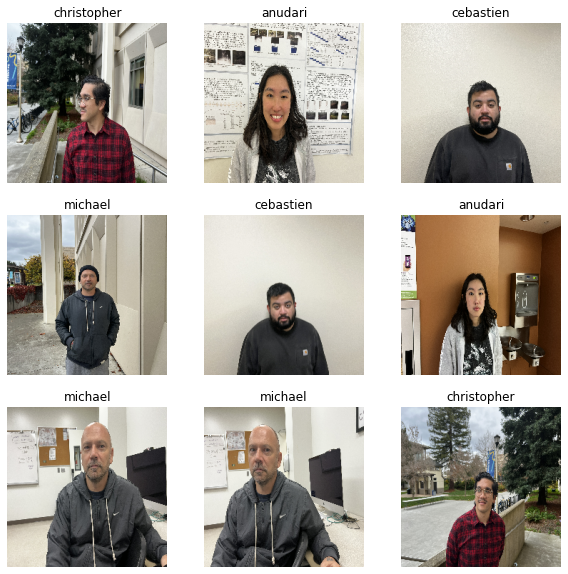

In [2]:
## Visualize the Data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
# Data Augmentation
# Because our model is overfitting

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
#     layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
  ]
)

2022-12-03 04:49:06.173707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 176 of 256
2022-12-03 04:49:10.688107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


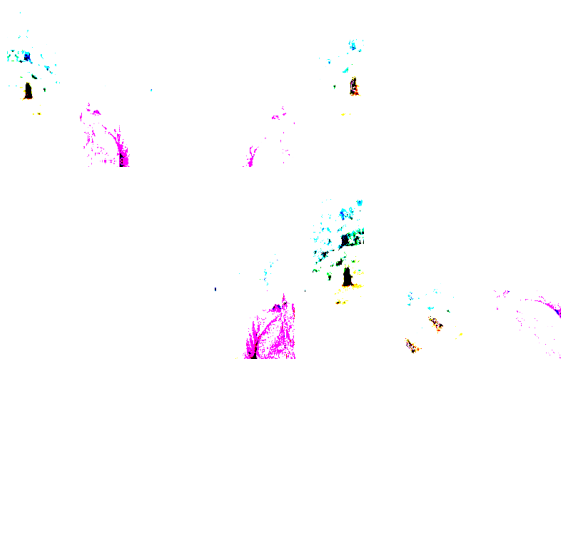

In [4]:
image, label = next(iter(train_ds))

# form image batches
# image = tf.cast(tf.expand_dims(image, 0), tf.float32)

# plotting
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2022-12-03 04:49:23.619980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 172 of 256
2022-12-03 04:49:28.449583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


(32, 224, 224, 3)
(32,)


2022-12-03 04:49:30.146114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
train_aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

val_aug_ds = validation_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
from keras.applications.vgg19 import VGG19
vgg19_model = VGG19(weights='imagenet',include_top=False)


80150528/80134624 [==============================] - 0s 0us/step


In [9]:
x=vgg19_model.output
from keras.layers import Dense,GlobalAveragePooling2D

x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(class_count, activation='softmax')(x) #final layer with softmax activation


In [10]:
from keras.models import Model
newModel=Model(inputs=vgg19_model.input,outputs=preds)

In [11]:
from keras.callbacks import ModelCheckpoint
# autosave best Model
best_model_file = "michael_model_with_aug_v3.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

In [12]:
import datetime
# Train the Model
# Train the model for 10 epochs with the Keras Model.fit method
newModel.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0006),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [13]:
NUM_EPOCHS = 10

history = newModel.fit(train_aug_ds,
                    validation_data=val_aug_ds,
                    epochs=NUM_EPOCHS, callbacks=[best_model])

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-12-03 04:49:42.950033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 169 of 256
2022-12-03 04:49:48.691692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-12-03 04:49:53.480123: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 62s 2s/step - loss: 1.3555 - sparse_categorical_accuracy: 0.4115 - val_loss: 0.8461 - val_sparse_categorical_accuracy: 0.7292

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.72917, saving model to michael_model_with_aug_v3.h5
Epoch 2/10
12/12 [==============================] - 11s 905ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.8047 - val_loss: 0.3424 - val_sparse_categorical_accuracy: 0.9271

Epoch 00002: val_sparse_categorical_accuracy improved from 0.72917 to 0.92708, saving model to michael_model_with_aug_v3.h5
Epoch 3/10
12/12 [==============================] - 11s 917ms/step - loss: 0.3207 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.2520 - val_sparse_categorical_accuracy: 0.9583

Epoch 00003: val_sparse_categorical_accuracy improved from 0.92708 to 0.95833, saving model to michael_model_with_aug_v3.h5
Epoch 4/10
12/12 [==============================] - 11s 919ms/step - loss: 0.1463 - sparse_categori

In [14]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


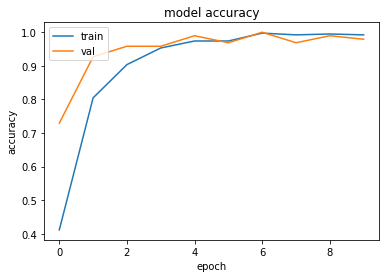

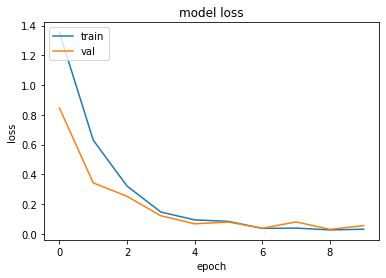

In [15]:
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# newModel.save("./michael_model_with_aug_v3.h5", save_format = 'h5')

In [17]:

keras.callbacks.TensorBoard(
    log_dir="/michael_model_with_aug_v3.h5",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
) 

2022-12-03 04:52:24.324730: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 04:52:24.324768: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-03 04:52:24.328524: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-12-03 04:52:25.217869: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 04:52:25.218075: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
